In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime

#Performance Plot
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

In [ ]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [ ]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [ ]:
# Pre-Processing Function

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading DAtaset from csv files to Pandas dataframes

dataset_train = pd.read_csv('/content/drive/MyDrive/Data/train1.csv')
dataset_test = pd.read_csv('/content/drive/MyDrive/Data/test1.csv')
print(dataset_train.head())
print(len(dataset_train))
print(dataset_test.head())
print(len(dataset_test))




   status_id                                        status_text          label
0        429  আপনি বানিয়ে বনিয়ে অল্পের মধ্যে খুব ভালো গল্প ল...  Agreeableness
1        342  আমি হাসপাতালে জব করি.. খুব কাছ থেকেই ডাক্তারদে...  Agreeableness
2        153  ধন্যবাদ ভাই আপনাকে গরিবের পাশে থাকার জন্য আল্ল...  Agreeableness
3        360  অবৈধ সম্পদের মালিক, মাদক সনত্রাসী গড ফাদার ক্য...  Agreeableness
4        367  বাংলাদেশকে ধাপে ধাপে এগিয়ে নিয়ে যাচ্ছেন নিজের ...  Agreeableness
2397
   status_id                                        status_text          label
0        191  দারু চিনি দ্বিপ ছবিতে উনার প্রথম অভিনয় দেখি, দ...  Agreeableness
1        409  ভাই, লিখতে থাকেন এই ভাব টা মেইনটেইন কইরা। হিমু...  Agreeableness
2        160            আপনার প্রতি ভালোবাসা দিন দিন বেড়েই চলছে  Agreeableness
3        132  আমি একটি এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা এবং ভ...  Agreeableness
4        180  ক্রিকেট মাঠে প্রতিপক্ষ কে দুমড়েমুচড়ে দিতে শুধু...  Agreeableness
603


In [ ]:
train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)
print(train.head())
print(len(train))
print(dataset_test.head())
print(len(dataset_test))


      status_id                                        status_text  \
2039        705  একটা পয়েন্ট বাদ পড়েছে। ইনটক্সিকেট করে যদি সম্ম...   
2037        879  আইন শৃংখলা বাহিনীকে অনেক অনেক ধন্যবাদ , এমন অব...   
415        2637  পড়তেই থাকি পড়তেই থাকি কিন্তু আতঁকা ক্যান যে আপ...   
2131        537  আমরা যুব সমাজ পারি,পঁচন ধরা এই সমাজটাকে হারামি...   
1984        661  আপনারা দিরিলিস চালু করুন। আর রবিবারের পরিবর্তে...   

                  label  
2039  Conscientiousness  
2037  Conscientiousness  
415            Openness  
2131  Conscientiousness  
1984  Conscientiousness  
2397
   status_id                                        status_text          label
0        191  দারু চিনি দ্বিপ ছবিতে উনার প্রথম অভিনয় দেখি, দ...  Agreeableness
1        409  ভাই, লিখতে থাকেন এই ভাব টা মেইনটেইন কইরা। হিমু...  Agreeableness
2        160            আপনার প্রতি ভালোবাসা দিন দিন বেড়েই চলছে  Agreeableness
3        132  আমি একটি এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা এবং ভ...  Agreeableness
4        180  ক্রিকেট ম

In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
def enum(text):
    if text=="Agreeableness":
      return "1"
    elif(text=="Conscientiousness"):
      return "2"
    elif(text=="Extroversion"):
      return "3"
    elif(text=="Neuroticism"):
      return "4"
    elif(text=="Openness"):
      return "5"

In [ ]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
l = le.fit_transform(dataset_train['label'])

for i in range(len(l)):
  #print(type(i))
  l[i]=l[i]+1

 
# printing label
l

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
# removing the column 'Purchased' from df
# as it is of no use now.
dataset_train.drop("label", axis=1, inplace=True)
 

# Appending the array to our dataFrame
# with column name 'Purchased'
dataset_train["label"] = l
 
# printing Dataframe
print(dataset_train.head())
print(len(dataset_train))

   status_id                                        status_text  label
0        429  আপনি বানিয়ে বনিয়ে অল্পের মধ্যে খুব ভালো গল্প ল...      1
1        342  আমি হাসপাতালে জব করি.. খুব কাছ থেকেই ডাক্তারদে...      1
2        153  ধন্যবাদ ভাই আপনাকে গরিবের পাশে থাকার জন্য আল্ল...      1
3        360  অবৈধ সম্পদের মালিক, মাদক সনত্রাসী গড ফাদার ক্য...      1
4        367  বাংলাদেশকে ধাপে ধাপে এগিয়ে নিয়ে যাচ্ছেন নিজের ...      1
2397


In [ ]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
#from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
l1 = le.fit_transform(dataset_test['label'])

for i in range(len(l1)):
  #print(type(i))
  l1[i]=l1[i]+1

 
# printing label
l1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
# removing the column 'Purchased' from df
# as it is of no use now.
dataset_test.drop("label", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
dataset_test["label"] = l1
 
# printing Dataframe
print(dataset_test.head())
print(len(dataset_test))

   status_id                                        status_text  label
0        191  দারু চিনি দ্বিপ ছবিতে উনার প্রথম অভিনয় দেখি, দ...      1
1        409  ভাই, লিখতে থাকেন এই ভাব টা মেইনটেইন কইরা। হিমু...      1
2        160            আপনার প্রতি ভালোবাসা দিন দিন বেড়েই চলছে      1
3        132  আমি একটি এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা এবং ভ...      1
4        180  ক্রিকেট মাঠে প্রতিপক্ষ কে দুমড়েমুচড়ে দিতে শুধু...      1
603


In [ ]:
dataset_train['status_text'] = dataset_train.status_text.apply(lambda x: preprocessing(str(x)))
dataset_test['status_text'] = dataset_test.status_text.apply(lambda x: preprocessing(str(x)))
#dataset_train['label'] = dataset_train.label.apply(lambda x: preprocessing(str(x)))
#dataset_test['label'] = dataset_test.label.apply(lambda x: preprocessing(str(x)))


print(dataset_train.head())
print(len(dataset_train))
print(dataset_test.head())
print(len(dataset_test))



   status_id                                        status_text  label
0        429  আপনি বানিয়ে বনিয়ে অল্পের মধ্যে খুব ভালো গল্প ল...      1
1        342  আমি হাসপাতালে জব করি খুব কাছ থেকেই ডাক্তারদের ...      1
2        153  ধন্যবাদ ভাই আপনাকে গরিবের পাশে থাকার জন্য আল্ল...      1
3        360  অবৈধ সম্পদের মালিক মাদক সনত্রাসী গড ফাদার ক্যা...      1
4        367  বাংলাদেশকে ধাপে ধাপে এগিয়ে নিয়ে যাচ্ছেন নিজের ...      1
2397
   status_id                                        status_text  label
0        191  দারু চিনি দ্বিপ ছবিতে উনার প্রথম অভিনয় দেখি দা...      1
1        409  ভাই লিখতে থাকেন এই ভাব টা মেইনটেইন কইরা হিমু হ...      1
2        160            আপনার প্রতি ভালোবাসা দিন দিন বেড়েই চলছে      1
3        132  আমি একটি এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা এবং ভ...      1
4        180  ক্রিকেট মাঠে প্রতিপক্ষ কে দুমড়েমুচড়ে দিতে শুধু...      1
603


In [ ]:
data1 =pd.read_excel('/content/drive/MyDrive/Data/stopwords_bangla.xlsx')
#print(data1)
stop = data1['words'].tolist()
print(stop)


['অই', 'অগত্যা', 'অত: পর', 'অতএব', 'অথচ', 'অথবা', 'অধিক', 'অধীনে', 'অধ্যায়', 'অনুগ্রহ', 'অনুভূত', 'অনুযায়ী', 'অনুরূপ', 'অনুসন্ধান', 'অনুসরণ', 'অনুসারে', 'অনুসৃত', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অন্যত্র', 'অন্যভাবে', 'অন্যান্য', 'অপেক্ষাকৃতভাবে', 'অবধি', 'অবশ্য', 'অবশ্যই', 'অবস্থা', 'অবিলম্বে', 'অভ্যন্তরস্থ', 'অর্জিত', 'অর্থাত', 'অসদৃশ', 'অসম্ভাব্য', 'আইন', 'আউট', 'আক্রান্ত', 'আগামী', 'আগে', 'আগেই', 'আগ্রহী', 'আছে', 'আজ', 'আট', 'আদেশ', 'আদ্যভাগে', 'আন্দাজ', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদিগের', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'আশি', 'আশু', 'আসা', 'আসে', 'ই', 'ইচ্ছা', 'ইচ্ছাপূর্বক', 'ইতিমধ্যে', 'ইতোমধ্যে', 'ইত্যাদি', 'ইশারা', 'ইহা', 'ইহাতে', 'উক্তি', 'উচিত', 'উচ্চ', 'উঠা', 'উত্তম', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'উপলব্ধ', 'উপায়', 'উভয়', 'উল্লেখ', 'উল্লেখযোগ্যভাবে', 'উহার', 'ঊর্ধ্বতন', 'এ', 'এপর্যন্ত', 'এঁদের', 'এঁরা', 'এই', 'এইগুলো', 'এইভাবে', 'এক', 'একই', 'একটি', 'একদা', 'একবার', 'একভাবে', 'একরকম', 'একসঙ্গে', 'একা', 'একে', 'এক্', 'এখন', 'এখনও', 'এখ

In [ ]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [ ]:
dataset_train['status_text'] = dataset_train.status_text.apply(lambda x: stopwordRemoval(str(x)))
dataset_test['status_text'] = dataset_test.status_text.apply(lambda x: stopwordRemoval(str(x)))
print(train.head())
print(len(train))
print(dataset_test.head())
print(len(dataset_test))


      status_id                                        status_text  \
2039        705  একটা পয়েন্ট বাদ পড়েছে। ইনটক্সিকেট করে যদি সম্ম...   
2037        879  আইন শৃংখলা বাহিনীকে অনেক অনেক ধন্যবাদ , এমন অব...   
415        2637  পড়তেই থাকি পড়তেই থাকি কিন্তু আতঁকা ক্যান যে আপ...   
2131        537  আমরা যুব সমাজ পারি,পঁচন ধরা এই সমাজটাকে হারামি...   
1984        661  আপনারা দিরিলিস চালু করুন। আর রবিবারের পরিবর্তে...   

                  label  
2039  Conscientiousness  
2037  Conscientiousness  
415            Openness  
2131  Conscientiousness  
1984  Conscientiousness  
2397
   status_id                                        status_text  label
0        191  দারু চিনি দ্বিপ ছবিতে উনার অভিনয় দেখি দারুন অভিনয়      1
1        409  ভাই লিখতে ভাব মেইনটেইন কইরা হিমু হিমু লাগে বহু...      1
2        160                                ভালোবাসা বেড়েই চলছে      1
3        132  এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা ভরণপোষণ দায়িত্...      1
4        180  ক্রিকেট মাঠে প্রতিপক্ষ দুমড়েমুচড়ে ব্যাটহাতে ব্...

In [ ]:

#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

dataset_test['status_text']=dataset_test['status_text'].apply(stem_text)
dataset_train['status_text']=dataset_train['status_text'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules.

In [ ]:
print(dataset_train.head())
print(len(dataset_train))
print(dataset_test.head())
print(len(dataset_test))

   status_id                                        status_text  label
0        429        বানা বনা অল্প ভালো গল্প লেখেনমাঝে মাঝে ঘটনা      1
1        342  হাসপাতালে জব ডাক্তার ডেডিকেশান দেখি পেশেন্ট বে...      1
2        153  ধন্যবাদ ভাই আপনা গরিব থাকা আল্লাহ আপনা সবসময় ...      1
3        360  অবৈধ সম্প মালিক মাদক সনত্রাসী গড ফাদা ক্য ঘুষ ...      1
4        367  বাংলাদেশ ধাপে ধাপে এগা যায় বিচক্ষণতা ষড়যন্ত্রক...      1
2397
   status_id                                        status_text  label
0        191      দারু চিনি দ্বিপ ছবি উন অভিনয় দেখি দারুন অভিনয়      1
1        409  ভাই লিখ ভাব মেইনটেইন কইরা হিমু হিমু লাগে বহুদি...      1
2        160                                    ভালোবাসা বাড় চল      1
3        132  এতিম বাচ্চা ছেলের হাফেজ পড়াশোনা ভরণপোষণ দায়িত্...      1
4        180  ক্রিকেট মাঠে প্রতিপক্ষ দুমড়েমুচড়ে ব্যাটহা ব্যা...      1
603


In [ ]:
train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)
print(train.head())
print(len(train))
print(test.head())
print(len(test))

      status_id                                        status_text  label
235         383                  টাকা গূলো এতিম খানায় আহ্বান জানা      1
2308        680  অবিবাহিত মায় খাবারঅল্প পরিশ্রমহরমোনাল কারন কার...      2
668        2814          কাক ব্লাকমেইল বোঝা বড় দায় নিজ নিজ স্বার্থ      5
1329       1866  সম্মান ব্যাপারটা ক্যাস্পস সিনিয়র কিনচিৎ বুঝানো...      4
1667       1242  প্রচন্ড রাগ দুখে গ্রীন কার্ডটা ছিঁড়ে ফেলেছি স্...      3
2397
     status_id                                        status_text  label
113        862                   রাষ্ট্রনায়ক শেখ হাসিনা লোক শাসন      2
507       2668  শাকিব খান পূর্নদৈঘ্য প্রেম কাহিনী যাদুর ব্যাট ...      5
19         272               অনুভুতি হয়ত বাবা সুন্দর লেখ পারবে না      1
339       2287  দায়িত্বে অযোগ্য নেতা মেয়র মন্ত্রী কোনোদিন ডাস্...      4
526       2823  চিটাগাং বাংলাদেশের একমাত্র শহর কংক্রিট জঙ্গল শ...      5
603


In [ ]:
test = dataset_test.sample(frac=1)

x=dataset_train.sample(frac=1)
x=pd.concat([x,x])
print(len(x))
print(x.head())
train = x.iloc[600:,:]
print(train.head())
print(x.head())
print(len(train))
print(len(x))
print("val\n\n")
val = x.iloc[:600]

#print(train.head())
print(x.head())
#print(len(train))
print(val.head())
print(len(val))
print(x.head())
print(len(x))



4794
      status_id                                        status_text  label
1019       2298  শেয় বাজা কেলেংকারীতে গ্রাহক টাকা মার খেল টিআইব...      4
1361       1930  জিন্না এককভাবে দোষারোপ ইতিহাসকে একপা বল পার্থক...      4
90          505                          আল্লাহর সৃষ্ কখনো পারবেনা      1
663        2586  সাংস্কৃতিক অনুষ্ঠান পুলিশ অনুমতি লাগবে বাংলাদে...      5
788        2463  পকেট শার্ট প্যান্ট পড় বুদ্ধি হুমায়ূন আহমেদ গিয়...      5
      status_id                                        status_text  label
739        2509  অনেকদিন লেখা আপনা ফেবু তে না পাল পেজ পাইতাম পা...      5
2064        593                         বোরো ধান বাম্প ফলন দাম কমা      2
648        2450           পুলিশে কথা পাই নাহ মাইর ডিম মাইর চলবে না      5
2132        900  দুর্নীতি না থাকলে চট্টগ্রাম শহরবিভাগজেলা উন্নত হত      2
825        2756  এক ব্যাংক খুললেওতো বেক পুলাপাইন ফ্যাশনেবল চুইট...      5
      status_id                                        status_text  label
1019       2298  শেয় বাজা কেলেংকা

In [ ]:
X_train = train['status_text'].values
y_train = train['label'].values

X_val = val['status_text'].values
y_val = val['label'].values

X_test = test['status_text'].values
y_test = test['label'].values

In [ ]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [ ]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [ ]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=8281
Number of Reviews=4194


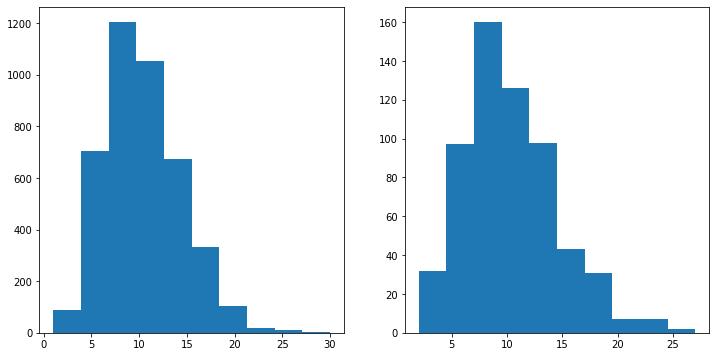

In [ ]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
# Padding the dataset to a maximum review length in words

MAX_SEQUENCE_LENGTH = 600

X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# Encoding Labels

le = LabelEncoder()
num_classes=5

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [ ]:
# Setting Vocabulary size and Emmbedding size

VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 250

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 2

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [ ]:
# Creating the model

model = Sequential()
# The Embedding layer
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# The first one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
# The first Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The first Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The second one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The second Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The second Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The third one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The third Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The third Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The Flattening layer
model.add(Flatten())
# The First Dense Layer (256,relu)
model.add(Dense(256, activation='relu'))
# The Second Dense Layer or Prediction layer (1,sigmoid)
model.add(Dense(5, activation='softmax'))
# Compiling the Model using the Binary_Crossontropy as a loss function and accuracy as a meseaure and Adam as an Optimizer
model.compile(loss='SparseCategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
# Displaying the Model Schema
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 600, 250)          2070250   
                                                                 
 conv1d_6 (Conv1D)           (None, 600, 32)           32032     
                                                                 
 conv1d_7 (Conv1D)           (None, 600, 32)           4128      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 32)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 300, 32)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 300, 64)           8256      
                                                      

In [ ]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=400, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/400
66/66 [==============================] - 38s 553ms/step - loss: 1.6061 - accuracy: 0.2179 - val_loss: 1.5997 - val_accuracy: 0.2517
Epoch 2/400
66/66 [==============================] - 37s 565ms/step - loss: 1.6046 - accuracy: 0.2256 - val_loss: 1.6008 - val_accuracy: 0.2517
Epoch 3/400
66/66 [==============================] - 36s 549ms/step - loss: 1.6028 - accuracy: 0.2258 - val_loss: 1.5932 - val_accuracy: 0.2600
Epoch 4/400
66/66 [==============================] - 39s 590ms/step - loss: 1.5960 - accuracy: 0.2310 - val_loss: 1.5642 - val_accuracy: 0.2250
Epoch 5/400
66/66 [==============================] - 37s 563ms/step - loss: 1.3532 - accuracy: 0.3858 - val_loss: 1.1641 - val_accuracy: 0.4733
Epoch 6/400
66/66 [==============================] - 36s 550ms/step - loss: 0.7799 - accuracy: 0.6903 - val_loss: 0.7685 - val_accuracy: 0.6683
Epoch 7/400
66/66 [==============================] - 36s 550ms/step - loss: 0.4354 - accuracy: 0.8464 - val_loss: 0.7960 - val_accuracy:

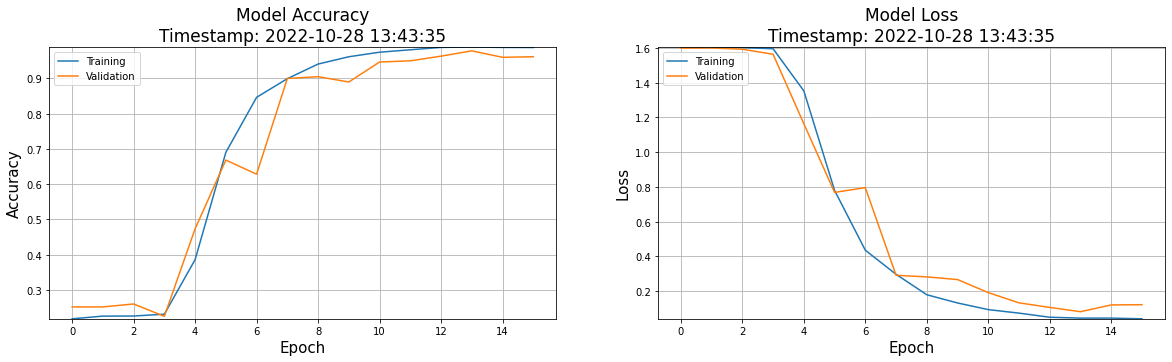

In [ ]:
#Accuracy / Validation_Accuracy  and Loss / Validation_Loss Plot

plot_performance(history=history1)

In [ ]:
# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

19/19 [==============================] - 1s 62ms/step - loss: 14.2660 - accuracy: 0.2504
Accuracy: 25.04%


In [ ]:
model.save('5_class_personality_cnn')

###LSTM

In [ ]:
import pandas as pd
import re

dft=dataset_train
dftx=dataset_test
df=pd.concat([dft, dftx])
df=pd.concat([df, df])
df= df.sample(frac=1)
print(len(df))
print(df.head(), "\n\n" , df.tail(), "\n\n", df)


6000
      status_id                                        status_text  label
269        1568  ধার না অসাধারণ ম্যারাথন শুরুর নমুনা সীমানা বহু...      3
210         480  যোগ্যতা অপেক্ষা ভাব শিক্ষা আজেবাজে কথা না বিনয়...      1
242        1377  খাওয় হ্যান্ড ওয়াশ হাত ধুইসবসময় হাত না ধুয় কেমন...      3
170         390  চট্টগ্রাম পরিবেশ প্রকৃতি অসাধারণ কাজে তৈরী সুদ...      1
2166        889  বিনোদন আপনা পাই প্রতিদিন খবর কাগজেফেইসবুকে বিন...      2 

       status_id                                        status_text  label
1533       1549       কোরিয়া প্রায় তোমা দেশ বলি আল্লাহ গো আমগো দেশ      3
2311        854  দেশের ঠিকমত খেত পারেনা একজন নেত বাসায় নগদ কোট...      2
944        2380                     দেশের সরক প্লাস্টিক কারখানা না      5
1933       1163  কিউরিয়াস মাইন্ডে চাই ভাই পোষ্ট সকল পুলিশ ব্যান...      3
2066        827  ভায়োলেন্স পছন্দ অন্য অপমান অপদস্থ পছন্দ জন্তু ...      2 

       status_id                                        status_text  label
269        1568  ধার না অসা

In [ ]:
df.head()

,status_id,status_text,label
269,1568,ধার না অসাধারণ ম্যারাথন শুরুর নমুনা সীমানা বহু...,3
210,480,যোগ্যতা অপেক্ষা ভাব শিক্ষা আজেবাজে কথা না বিনয়...,1
242,1377,খাওয় হ্যান্ড ওয়াশ হাত ধুইসবসময় হাত না ধুয় কেমন...,3
170,390,চট্টগ্রাম পরিবেশ প্রকৃতি অসাধারণ কাজে তৈরী সুদ...,1
2166,889,বিনোদন আপনা পাই প্রতিদিন খবর কাগজেফেইসবুকে বিন...,2


In [ ]:
df=df.drop('status_id',axis=1)
print(dataset_train.head())
print(df.head())


   status_id                                        status_text  label
0        429        বানা বনা অল্প ভালো গল্প লেখেনমাঝে মাঝে ঘটনা      1
1        342  হাসপাতালে জব ডাক্ত ডেডিকেশান দেখি পেশেন্ট বেস্...      1
2        153  ধন্যবাদ ভাই আপনা গরিব থাকা আল্লাহ আপনা সবসময় ...      1
3        360  অবৈধ সম্প মালিক মাদক সনত্রাসী গড ফাদা ক্য ঘুষ ...      1
4        367  বাংলাদেশ ধাপে ধাপে এগা যায় বিচক্ষণতা ষড়যন্ত্রক...      1
                                            status_text  label
269   ধার না অসাধারণ ম্যারাথন শুরুর নমুনা সীমানা বহু...      3
210   যোগ্যতা অপেক্ষা ভাব শিক্ষা আজেবাজে কথা না বিনয়...      1
242   খাওয় হ্যান্ড ওয়াশ হাত ধুইসবসময় হাত না ধুয় কেমন...      3
170   চট্টগ্রাম পরিবেশ প্রকৃতি অসাধারণ কাজে তৈরী সুদ...      1
2166  বিনোদন আপনা পাই প্রতিদিন খবর কাগজেফেইসবুকে বিন...      2


In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
max_fatures = 2500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['status_text'].values)
X = tokenizer.texts_to_sequences(df['status_text'].values)
X = pad_sequences(X)

In [ ]:
X

array([[   0,    0,    0, ..., 1224, 2193,  633],
       [   0,    0,    0, ..., 2194, 1006,   49],
       [   0,    0,    0, ..., 1225,  402,   72],
       ...,
       [   0,    0,    0, ..., 2185, 2119,    1],
       [   0,    0,    0, ...,  188,   19,    1],
       [   0,    0,    0, ...,  608,    1,   10]], dtype=int32)

In [ ]:
np.shape(X)

(6000, 23)

In [ ]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 64)            160000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 23, 64)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 193,349
Trainable params: 193,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y = pd.get_dummies(df['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4800, 23) (4800, 5)
(1200, 23) (1200, 5)


In [ ]:
history=model.fit(X_train, Y_train, epochs = 50, batch_size=32, verbose = 2,validation_split=0.1)

Epoch 1/50
135/135 - 6s - loss: 1.5921 - acc: 0.2484 - val_loss: 1.5594 - val_acc: 0.3688 - 6s/epoch - 47ms/step
Epoch 2/50
135/135 - 4s - loss: 1.3753 - acc: 0.4493 - val_loss: 1.2998 - val_acc: 0.4896 - 4s/epoch - 28ms/step
Epoch 3/50
135/135 - 4s - loss: 0.9805 - acc: 0.6317 - val_loss: 1.1844 - val_acc: 0.5521 - 4s/epoch - 28ms/step
Epoch 4/50
135/135 - 4s - loss: 0.7140 - acc: 0.7493 - val_loss: 1.1240 - val_acc: 0.5750 - 4s/epoch - 28ms/step
Epoch 5/50
135/135 - 4s - loss: 0.5547 - acc: 0.8093 - val_loss: 1.0485 - val_acc: 0.6542 - 4s/epoch - 27ms/step
Epoch 6/50
135/135 - 4s - loss: 0.4358 - acc: 0.8519 - val_loss: 1.0438 - val_acc: 0.6896 - 4s/epoch - 28ms/step
Epoch 7/50
135/135 - 4s - loss: 0.3521 - acc: 0.8847 - val_loss: 1.0498 - val_acc: 0.7229 - 4s/epoch - 27ms/step
Epoch 8/50
135/135 - 4s - loss: 0.2881 - acc: 0.8995 - val_loss: 1.0472 - val_acc: 0.7417 - 4s/epoch - 28ms/step
Epoch 9/50
135/135 - 4s - loss: 0.2379 - acc: 0.9218 - val_loss: 1.1134 - val_acc: 0.7375 - 4s/e

In [ ]:
score = model.evaluate(X_train, Y_train,batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

75/75 - 1s - loss: 0.1782 - acc: 0.9756 - 878ms/epoch - 12ms/step
Train loss: 0.1781684011220932
Train accuracy: 0.9756249785423279


In [ ]:
score = model.evaluate(X_test, Y_test,batch_size=64, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 - 0s - loss: 5.6890 - acc: 0.2700 - 94ms/epoch - 9ms/step
Test loss: 5.688978672027588
Test accuracy: 0.27000001072883606


add tokenizer 

In [ ]:

def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.status_text)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.status_text)
  word_index = tokenizer.word_index
  #print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  #print(dataset.status_text[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.status_text[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open(path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000

corpus,labels = encoded_texts(d_set,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)
     

In [ ]:
embedding_dimension = 128
input_length = 300
vocab_size = 5000
num_classes = 12
batch_size = 64
num_epochs = 10

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)


###bert as 

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 15.4 MB/s 
     |████████████████████████████████| 441 kB 57.7 MB/s 
     |████████████████████████████████| 163 kB 62.5 MB/s 
     |████████████████████████████████| 7.6 MB 49.1 MB/s 
     |████████████████████████████████| 115 kB 48.6 MB/s 
     |████████████████████████████████| 212 kB 83.5 MB/s 
     |████████████████████████████████| 127 kB 60.5 MB/s 
     |████████████████████████████████| 115 kB 51.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 44.7 MB/s 
     |████████████████████████████████| 163 kB 57.3 MB/s 


In [ ]:
!pip install torch
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
classifier("We are very happy to show you the 🤗 Transformers library.")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "csebuetnlp/banglabert"


model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.config


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

ElectraConfig {
  "_name_or_path": "csebuetnlp/banglabert",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [ ]:
X=list(dataset_train['status_text'])
Y=list(dataset_train['label'])
print(Y)
print(X)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
X.shape()

AttributeError: ignored

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
x

{'input_ids': [[2, 1581, 795, 4638, 17722, 10341, 5818, 7313, 10200, 14342, 798, 25118, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 8074, 2817, 1221, 2490, 30697, 917, 795, 1, 5036, 1755, 15559, 6848, 430, 2864, 410, 6653, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 8173, 1, 1190, 1, 1190, 795, 1, 12165, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2537, 2404, 5137, 4638, 2179, 4544, 7081, 847, 1, 2920, 470, 6766, 19349, 416, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 11962, 11770, 2093, 3117, 1691, 8385, 2684, 424, 1120, 1635, 11962, 795, 13395, 8308, 2079, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 8645, 12307, 3596, 795, 12307, 8645, 3596, 1561, 763, 418, 3098, 8233, 6509, 428, 15909, 795, 440, 2768, 1020, 13615, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 5889, 4750, 1137, 1213, 3, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
np.shape(x)

(3,)

In [ ]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 64)            160000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 23, 64)           0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 193,349
Trainable params: 193,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y = pd.get_dummies(df['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(x,Y, test_size = 0.20,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

ValueError: ignored

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
classifier(" আপনার প্রতি ভালোবাসা দিন দিন বেড়েই চলছে")

[{'label': 'LABEL_1', 'score': 0.5010454058647156}]

In [ ]:
tokens = tokenizer.encode_plus(sent, add_special_tokens-False,
return_tensors='pt',)

NameError: ignored